In [105]:
using Pkg
Pkg.instantiate()

In [43]:
#import Pkg; Pkg.add("NIfTI")
using NIfTI                  
#import Pkg; Pkg.add("RegressionDynamicCausalModeling")
using RegressionDynamicCausalModeling
using Statistics
#import Pkg; Pkg.add("StatsBase")
using StatsBase #for spearman
#import Pkg; Pkg.add("Plots")
using Plots
using Random
#import Pkg; Pkg.add("LinearAlgebra")
using LinearAlgebra

using DelimitedFiles
using MAT            # for saving .mat files
using Glob
using Printf

In [3]:
function extract_timeseries(subject::String; 
                             data_dir::String="/Users/schmieschekm/Desktop/dpabi_final/FunImgARCFW", 
                             mask_dir::String="/Users/schmieschekm/Desktop/dpabi_final/Brainnetome2016/BNA_PM_3D_246_bin_unzip")
    # 1) load rsfMRI
    func_path = joinpath(data_dir, subject, "wFiltered_4DVolume.nii")
    fmri = niread(func_path)                     # NIfTI.jl :contentReference[oaicite:2]{index=2}
    vol4d = fmri.raw                             # raw array dims (X,Y,Z,T)
    T = size(vol4d,4)                            # number of timepoints
    TR = time_step(fmri.header) / 1000           # header dt in ms → seconds
    println("func size = ", size(vol4d))

    # 2) list all masks and preallocate
    mask_files = sort(readdir(mask_dir))
    nroi = length(mask_files)
    ts = zeros(nroi, T)

    # 3) loop over masks, extract ROI‐mean
    vol2d = reshape(vol4d, :, T)  # voxels × time
    for (i, mf) in enumerate(mask_files)
        mnii = niread(joinpath(mask_dir, mf))
        println("mask size = ", size(mnii))
        mask = mnii.raw .> 0                      # boolean mask :contentReference[oaicite:3]{index=3}
        roi_data = vol2d[vec(mask), :]            # select masked voxels
        ts[i, :] = mean(roi_data; dims=1)[:]      # mean across voxels
    end

    return ts, TR, mask_files
end

extract_timeseries (generic function with 1 method)

In [4]:
function extract_timeseries_by_label(func_dir::String, func_fileName::String, atlas_dir::String, atlas_fileName::String, subject::String)
    # 1) load data
    func_path = joinpath(func_dir, subject, func_fileName)
    println(func_path)
    atlas_path = joinpath(atlas_dir, atlas_fileName)
    func_nii  = niread(func_path)
    atlas_nii = niread(atlas_path)

    vol4d = func_nii.raw                     # Float32[X,Y,Z,T]
    atlas = atlas_nii.raw                    # Int or Float labels [X,Y,Z]
    dims3 = size(atlas)
    T     = size(vol4d, 4)
    TR    = time_step(func_nii.header) / 1000  # ms → s

    # flatten spatial dims
    vol2d = reshape(vol4d, prod(dims3), T)     # (voxels × time)
    atlas1 = vec(atlas)                        # (voxels)

    # 2) find unique nonzero labels
    regs = sort(unique(atlas1))
    regs = filter(!=(0), regs)                 # drop background 0

    # 3) for each label, average the voxels
    nreg = length(regs)
    ts   = zeros(Float64, nreg, T)

    for (i, lbl) in enumerate(regs)
        mask_vec = atlas1 .== lbl              # Bool[voxels]
        if !any(mask_vec)
            @warn "No voxels found for label $lbl in atlas"
            continue
        end
        roi_data = vol2d[mask_vec, :]          # (nVoxels × T)
        ts[i, :] = mean(roi_data; dims=1)[:]   # 1×T → T
    end

    return ts, regs, TR
end

extract_timeseries_by_label (generic function with 1 method)

In [5]:
function compute_functional_connectivity(ts::AbstractMatrix{<:Real};
                                         method::Symbol = :pearson,
                                         fisher_z::Bool = false)
    nroi, _ = size(ts)
    C = zeros(Float64, nroi, nroi)

    if method == :pearson
        for i in 1:nroi
            for j in i:nroi
                r = cor(ts[i, :], ts[j, :])
                if fisher_z
                    # clamp to avoid infinities
                    r_clamped = clamp(r, -0.9999, 0.9999)
                    val = atanh(r_clamped)
                else
                    val = r
                end
                C[i, j] = val
                C[j, i] = val
            end
        end

    elseif method == :covariance
        # cov(ts') returns ROI×ROI covariance
        C = cov(ts')
    else
        throw(ArgumentError("Unsupported method: $method; choose :pearson or :covariance"))
    end

    return C
end

compute_functional_connectivity (generic function with 1 method)

In [6]:
function estimate_rdcm(ts::Matrix{Float64}, TR::Float64; verbose::Int=1, A::BitMatrix=nothing)
    nroi, scans = size(ts)
    #print(scans)
    for i in 1:nroi
        A[i,i] = true
    end

    # 2) no driving inputs
    C = falses(nroi, 0)

    # 3) package the BOLD data: expects scans×regions
    Y    = RegressionDynamicCausalModeling.BoldY(ts', TR, nothing)  # :contentReference[oaicite:1]{index=1}

    # 4) no confounds
    r_dt = 16
    u_dt = TR / r_dt
    X_numOfSteps =  round(Int64, scans * TR / u_dt)
    #println("X_numOfSteps: ", X_numOfSteps)

    Conf = RegressionDynamicCausalModeling.Confound(zeros(X_numOfSteps, 0), String[])
   # println("Confound finished ")

    # 5) zero initial parameters for A and C
    Ep   = RegressionDynamicCausalModeling.TrueParamLinear(
               zeros(nroi, nroi),      # A‐parameters
               zeros(nroi, 0)           # C‐parameters
           )

    # 6) build a LinearDCM and convert to rigid rDCM
    dcm  = RegressionDynamicCausalModeling.LinearDCM(A, C, scans, nroi, nothing, Y, Ep, Conf)
    rdcm = RegressionDynamicCausalModeling.RigidRdcm(dcm)             # :contentReference[oaicite:2]{index=2}

    # 7) set inversion options and invert
    invpars = RegressionDynamicCausalModeling.RigidInversionParams()   # default maxIter, tol
    opt     = RegressionDynamicCausalModeling.Options(invpars; synthetic=false, verbose=verbose)
    output  = RegressionDynamicCausalModeling.invert(rdcm, opt)        # :contentReference[oaicite:3]{index=3}

    return rdcm, output
end


estimate_rdcm (generic function with 1 method)

In [49]:
using MAT
using FileIO
using Printf


function extract_allSubjectIDs(
    func_dir::String
)

    # Get subject folders and IDs
    subject_folders = filter(isdir, readdir(func_dir, join=true))
    subject_ids = [basename(folder) for folder in subject_folders]
    return subject_ids
end 


function extract_timeseries_for_all_subjects(
    func_dir::String,
    results_dir::String,
    func_fileName::String,
    atlas_dir::String,
    atlas_fileName::String;
    verbose::Bool = true
)

    # Get subject folders and IDs
    subject_folders = filter(isdir, readdir(func_dir, join=true))
    subject_ids = [basename(folder) for folder in subject_folders]

    for subject in subject_ids
        if verbose
            @printf("Extracting time series for subject: %s\n", subject)
        end

        # Call your custom function to extract time series (make sure this function is defined elsewhere)
        ts, labels, TR = extract_timeseries_by_label(
            func_dir, func_fileName,
            atlas_dir, atlas_fileName,
            subject
        )

        # Save path for the .mat file
        save_path = joinpath(results_dir, subject, "time_series.mat")
        mkpath(dirname(save_path))  # Create directories if needed

        # Save the results
        MAT.matwrite(save_path, Dict(
            "ts" => ts,
            "labels" => labels,
            "TR" => TR
        ))
    end

    if verbose
        println("Finished processing all subjects.")
    end
end

# === Function to compute and save functional connectivity ===
function compute_func_connectivity_for_all_subjects(results_dir::String; verbose::Bool=true)
    subject_folders = filter(isdir, readdir(results_dir, join=true))
    subject_ids = [basename(folder) for folder in subject_folders]

    for subject in subject_ids
        if verbose
            @printf("Computing functional connectivity for subject: %s\n", subject)
        end

        # Load extracted timeseries
        ts_data = MAT.matread(joinpath(results_dir, subject, "time_series.mat"))
        ts = ts_data["ts"]

        fc_mat = compute_functional_connectivity(ts)
        fc_z = compute_functional_connectivity(ts; fisher_z=true)
        cov_mat = compute_functional_connectivity(ts; method=:covariance)

        save_path = joinpath(results_dir, subject, "func_connectivity.mat")
        mkpath(dirname(save_path))

        MAT.matwrite(save_path, Dict(
            "fc_mat" => fc_mat,
            "fc_z" => fc_z,
            "cov_mat" => cov_mat
        ))
    end

    if verbose
        println("Finished computing connectivity for all subjects.")
    end
end


using DelimitedFiles
using MAT
using Printf

function estimate_rdcm_for_all_subjects(
    results_dir::String,
    atlas_filename::String,
    bna_matrix_filename::String;
    verbose::Bool = true
)

    # Load adjacency matrix
    A_array = readdlm(bna_matrix_filename, ',', Int)

    A_matrix = BitMatrix(A_array .== 1)

    subject_folders = filter(isdir, readdir(results_dir, join=true))
    subject_ids = [basename(folder) for folder in subject_folders]

    for subject in subject_ids
        if verbose
            @printf("\nProcessing subject: %s\n", subject)
        end

        ts_path = joinpath(results_dir, subject, "time_series.mat")
        if !isfile(ts_path)
            @warn "Skipping subject $subject: time series file not found."
            continue
        end

        data = MAT.matread(ts_path)
        ts = data["ts"]
        labels = data["labels"]
        TR = data["TR"]

        println("Estimate rDCM")
        rdcm, output = estimate_rdcm(ts, TR, verbose=  Int64(verbose::Bool) , A=A_matrix)

        println("Extracted $(length(labels)) region time series, TR=$(TR)s")

        # Also compute FC matrices for completeness
        fc_mat = compute_functional_connectivity(ts)
        fc_z = compute_functional_connectivity(ts; fisher_z=true)
        cov_mat = compute_functional_connectivity(ts; method=:covariance)

        save_path = joinpath(results_dir, subject, "rdcm_connectivity.mat")
        mkpath(dirname(save_path))

        MAT.matwrite(save_path, Dict(
            "output_m_all" => output.m_all
        ))
    end

    println("\nFinished estimating rDCM for all subjects.")
end



estimate_rdcm_for_all_subjects (generic function with 1 method)

In [44]:
using MAT
using Printf

function load_connectivity_data(
    results_dir::String;
    load_rdcm::Bool = true,
    load_functional::Bool = true,
    verbose::Bool = true
)
    subject_folders = filter(isdir, readdir(results_dir, join=true))
    subject_ids = [basename(folder) for folder in subject_folders]

    all_data = Dict{String, Dict{String, Any}}()

    for subject in subject_ids
        subj_data = Dict{String, Any}()

        if load_rdcm
            rdcm_path = joinpath(results_dir, subject, "rdcm_connectivity.mat")

            if isfile(rdcm_path)
                if verbose
                    @printf("Loading rDCM output for subject: %s\n", subject)
                end
                data = MAT.matread(rdcm_path)
                if haskey(data, "output_m_all")
                    subj_data["rdcm"] = data["output_m_all"]
                else
                    @warn "Missing 'output_m_all' in rDCM file for subject $subject"
                end
            else
                @warn "rDCM file not found for subject $subject"
            end
        end

        if load_functional
            func_path = joinpath(results_dir, subject, "func_connectivity.mat")

            if isfile(func_path)
                if verbose
                    @printf("Loading functional connectivity for subject: %s\n", subject)
                end
                data = MAT.matread(func_path)
                for k in ["fc_mat", "fc_z", "cov_mat"]
                    if haskey(data, k)
                        subj_data[k] = data[k]
                    else
                        @warn "Missing $k in functional connectivity file for subject $subject"
                    end
                end
            else
                @warn "Functional connectivity file not found for subject $subject"
            end
        end

        if !isempty(subj_data)
            all_data[subject] = subj_data
        end
    end

    println("\nFinished loading connectivity data.")
    return all_data
end

function mask_and_flatten_connectivity_data(connectivity_data::Dict{String, Dict{String, Any}}, bna_matrix_filename::String; mask::Bool=true)
    # Load the BNA mask
    A_array = readdlm(bna_matrix_filename, ',', Int)
    
    # Keys representing symmetric matrices
    symmetric_keys = Set(["fc_mat", "fc_z", "cov_mat"])

    # Prepare output dictionary
    masked_data = Dict{String, Dict{String, Vector{Float64}}}()

    for (subject, subj_data) in connectivity_data
        masked_subj = Dict{String, Vector{Float64}}()
        for key in ["rdcm", "fc_mat", "fc_z", "cov_mat"]
            if haskey(subj_data, key)
                mat = Array{Float64}(subj_data[key])
                A_matrix = BitMatrix(A_array .== 1)
                if key in symmetric_keys
                    # Zero out lower triangle
                    A_matrix = triu(A_matrix)  # Keeps upper triangle, sets lower triangle to 0
                    mask_idx = findall(A_matrix .== 1)
                else 
                    
                    mask_idx = findall(A_matrix .== 1)

                
                end
                if mask
                    # Apply BNA mask and flatten
                    vctr = mat[mask_idx]
                else
                    # Flatten the whole matrix (column-major)
                    vctr = vec(mat)
                end
                masked_subj[key] = vctr
            end
        end
        masked_data[subject] = masked_subj
    end
    return masked_data
end

# Example usage:
# masked_connectivity_vectors = mask_and_flatten_connectivity_data(connectivity_data, BNA_MATRIX_FILENAME; mask=true)
# all_connectivity_vectors = mask_and_flatten_connectivity_data(connectivity_data, BNA_MATRIX_FILENAME; mask=false)


mask_and_flatten_connectivity_data (generic function with 1 method)

In [45]:
using MAT
using FileIO
using Printf

# --- Input Configuration ---
#const FUNC_DIR = "C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW_n88"
#const RESULTS_DIR = "C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/connectivity_n88"
#const ATLAS_DIR = "C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data"

#const FUNC_FILENAME = "wFiltered_4DVolume.nii"
#const ATLAS_FILENAME = "BN_Atlas_246_3mm.nii"
#const BNA_MATRIX_FILENAME = "BNA_matrix_binary_246x246.csv"

#local
const FUNC_DIR = "/Users/schmieschekm/Desktop/ADNIDOD/FunImgARCFW_n88"
const RESULTS_DIR = "./connectivity_n88"
const ATLAS_DIR = "/Users/schmieschekm/Desktop/ADNIDOD/dpabi_final/Brainnetome2016"

const FUNC_FILENAME = "wFiltered_4DVolume.nii"
const ATLAS_FILENAME = "BN_Atlas_246_3mm.nii"
const BNA_MATRIX_FILENAME = "/Users/schmieschekm/Desktop/ADNIDOD/dpabi_final/Brainnetome2016/BNA_matrix_binary_246x246.csv"



"/Users/schmieschekm/Desktop/ADNIDOD/dpabi_final/Brainnetome2016/BNA_matrix_binary_246x246.csv"

In [ ]:
# === Run Pipeline ===

extract_timeseries_for_all_subjects(FUNC_DIR, RESULTS_DIR, FUNC_FILENAME, ATLAS_DIR, ATLAS_FILENAME)


In [122]:

compute_func_connectivity_for_all_subjects(RESULTS_DIR)


In [127]:

estimate_rdcm_for_all_subjects(
    RESULTS_DIR,
    ATLAS_FILENAME,
    BNA_MATRIX_FILENAME;
    verbose=true
)



In [46]:

# Load both rDCM and functional connectivity
connectivity_data = load_connectivity_data(RESULTS_DIR; load_rdcm=true, load_functional=true)

# To access:
# connectivity_data["000001"]["rdcm"]
# connectivity_data["000001"]["fc_mat"]
# connectivity_data["000001"]["fc_z"]
# connectivity_data["000001"]["cov_mat"]


Dict{String, Dict{String, Any}} with 88 entries:
  "0006315" => Dict("fc_z"=>[4.95172 0.48789 … 0.549809 0.381889; 0.48789 4.951…
  "0204420" => Dict("fc_z"=>[4.95172 0.729068 … -0.226596 -0.213471; 0.729068 4…
  "0222220" => Dict("fc_z"=>[4.95172 0.979198 … 0.289783 0.158959; 0.979198 4.9…
  "0375447" => Dict("fc_z"=>[4.95172 0.538022 … 0.349283 0.438651; 0.538022 4.9…
  "0212318" => Dict("fc_z"=>[4.95172 0.986412 … 0.0434219 0.307477; 0.986412 4.…
  "0211821" => Dict("fc_z"=>[4.95172 1.23286 … 0.198111 0.0902052; 1.23286 4.95…
  "0127024" => Dict("fc_z"=>[4.95172 0.714655 … 0.55379 0.398387; 0.714655 4.95…
  "0392851" => Dict("fc_z"=>[4.95172 0.960741 … 0.0562224 -0.0108732; 0.960741 …
  "0262939" => Dict("fc_z"=>[4.95172 0.418224 … 0.19417 0.256116; 0.418224 4.95…
  "0217126" => Dict("fc_z"=>[4.95172 1.72067 … -0.570715 -0.308627; 1.72067 4.9…
  "0237738" => Dict("fc_z"=>[4.95172 0.315127 … 0.141684 0.068505; 0.315127 4.9…
  "0177544" => Dict("fc_z"=>[4.95172 1.04398 … 0.302457 0.12

In [47]:
masked_connectivity_vectors = mask_and_flatten_connectivity_data(connectivity_data, BNA_MATRIX_FILENAME; mask=true)
connectivity_vectors = mask_and_flatten_connectivity_data(connectivity_data, BNA_MATRIX_FILENAME; mask=false)
# To access: same structure of as connectivity_data

Dict{String, Dict{String, Vector{Float64}}} with 88 entries:
  "0006315" => Dict("fc_z"=>[4.95172, 0.48789, 0.666035, 0.60114, 0.264075, 0.1…
  "0204420" => Dict("fc_z"=>[4.95172, 0.729068, 0.253725, 0.0633452, 0.184403, …
  "0222220" => Dict("fc_z"=>[4.95172, 0.979198, 0.624151, 0.531024, 0.356384, 0…
  "0375447" => Dict("fc_z"=>[4.95172, 0.538022, 0.288739, 0.255132, 0.164463, 0…
  "0212318" => Dict("fc_z"=>[4.95172, 0.986412, 0.807135, 0.553954, 0.762717, 0…
  "0211821" => Dict("fc_z"=>[4.95172, 1.23286, 1.33515, 1.17421, 1.11921, 1.008…
  "0127024" => Dict("fc_z"=>[4.95172, 0.714655, 0.11112, -0.0266893, 0.443285, …
  "0392851" => Dict("fc_z"=>[4.95172, 0.960741, 0.519674, 0.263751, 0.309167, 0…
  "0262939" => Dict("fc_z"=>[4.95172, 0.418224, 0.560234, 0.604622, 0.576573, 0…
  "0217126" => Dict("fc_z"=>[4.95172, 1.72067, 1.19286, 1.17311, 1.50067, 1.398…
  "0237738" => Dict("fc_z"=>[4.95172, 0.315127, 0.467068, 0.224237, 0.259165, 0…
  "0177544" => Dict("fc_z"=>[4.95172, 1.04398, 0

In [50]:
subjectIDs =  extract_allSubjectIDs(FUNC_DIR)

88-element Vector{String}:
 "0006315"
 "0080428"
 "0088343"
 "0119126"
 "0120313"
 "0127024"
 "0129331"
 "0130013"
 "0140824"
 "0141624"
 ⋮
 "0391243"
 "0391748"
 "0392851"
 "0394956"
 "0395756"
 "0396556"
 "0398560"
 "0400016"
 "0400117"

In [51]:
using TSne
using Plots
using Statistics

# Example:
# masked_connectivity_vectors = Dict("000001" => Dict("rdcm" => [0.1, 0.2, 0.3]), ...)

# Extract the connectivity vectors into a matrix
function get_connectivity_matrix(masked_connectivity_vectors::Dict{String, Dict{String, Vector{Float64}}}, subjectIDs::Vector{String})
    data = []
    for id in subjectIDs
        if haskey(masked_connectivity_vectors, id) && haskey(masked_connectivity_vectors[id], "rdcm")
            push!(data, masked_connectivity_vectors[id]["rdcm"])
        else
            error("Missing connectivity data for subject ID: $id")
        end
    end
    return reduce(vcat, [x' for x in data])  # Matrix: rows = subjects, columns = features
end
rescale(A; dims=1) = (A .- mean(A, dims=dims)) ./ max.(std(A, dims=dims), eps())

# Run t-SNE
function run_tsne(connectivity_matrix::Matrix{Float64}; dims::Int=2, perplexity::Int=30)
    connectivity_matrix = rescale(connectivity_matrix, dims=1)  # Normalize each feature to [0, 1]
    # Check if the matrix is empty
    
    tsne_result = tsne(connectivity_matrix, dims,  0,   1000 , perplexity)
    return tsne_result
end

# Plot t-SNE result
function plot_tsne(tsne_result::Matrix{Float64}, subjectIDs::Vector{String})
    scatter(tsne_result[:, 1], tsne_result[:, 2], title="t-SNE of Subject Connectivity",
            xlabel="Dim 1", ylabel="Dim 2", legend=false)
end

# Main execution
connectivity_matrix = get_connectivity_matrix(masked_connectivity_vectors, subjectIDs)


88×22120 Matrix{Float64}:
  0.107489      0.111779    0.345441     …   0.39576      0.00535521
  0.162832     -0.0644127  -0.0391889       -0.087675    -0.0292115
 -0.0338082     0.169049    0.0964485        0.104097     0.0498591
  0.103154      0.164246    0.134434         0.095402     0.163808
 -0.000581492  -0.116375   -0.158866         0.165891    -0.182747
  0.0505614    -0.035859   -0.0210005    …  -0.0185157    0.0478643
  0.103987     -0.0277521   0.137925         0.0726806   -0.0186271
  0.0232569    -0.117037   -0.106732         0.00885573   0.038989
  0.130828     -0.0584908  -0.123597        -0.084112    -0.00188136
 -0.258997     -0.0132141   0.0118816        0.105739     0.0475802
  ⋮                                      ⋱               
 -0.00239867    0.109107    0.0315021        0.0175576   -0.0563767
  0.0729354    -0.124003   -0.000954119  …   0.125394    -0.0122788
 -0.0757285    -0.317197   -0.327113         0.116276    -0.0470462
  0.088398      0.0434772  -0.013

In [23]:

tsne_result = run_tsne(connectivity_matrix; dims= 2, perplexity=45)


88×2 Matrix{Float64}:
  106.446     227.173
  -67.2949     -9.49561
    0.52152    21.7184
   18.7865     50.3062
   -4.93843   -43.8553
   94.5811   -221.434
   61.7246     62.6664
  -32.8317      6.1453
   22.2936      1.85041
 -168.506    -201.037
    ⋮        
  133.659      25.0292
  -52.0078    161.905
   27.4235     88.7471
  209.953     -11.3324
  110.657     -15.5026
  109.936      67.3653
  -56.544    -182.743
  266.7       -72.6793
  279.236      17.9323

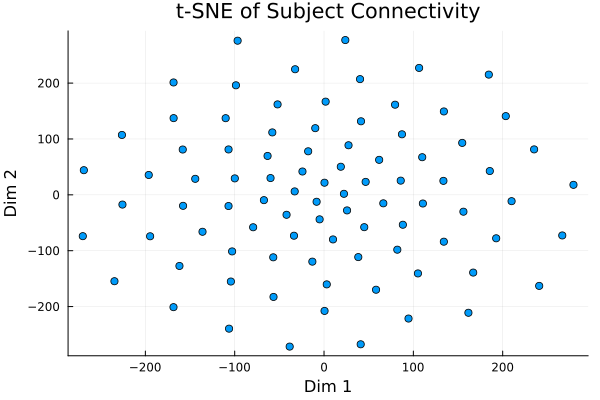

In [24]:
plot_tsne(tsne_result, subjectIDs)


In [25]:
n = size(fc_mat, 1)

heatmap(
    fc_mat;
    aspect_ratio = 1,          # square
    xlabel       = "ROI",      
    ylabel       = "ROI",
    xticks       = (1:n, string.(1:n)),
    yticks       = (1:n, string.(1:n)),
    title        = "Functional Connectivity Matrix",
    colorbar     = true
)

UndefVarError: UndefVarError: `fc_mat` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

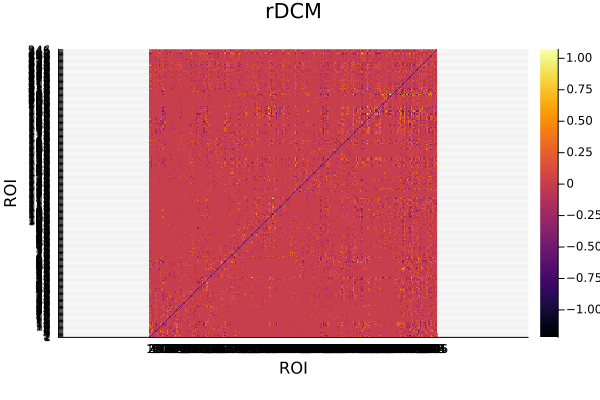

In [143]:
n = size(output.m_all, 1)

heatmap(
    connectivity_data["0006315"]["rdcm"];
    aspect_ratio = 1,          # square
    xlabel       = "ROI",      
    ylabel       = "ROI",
    xticks       = (1:n, string.(1:n)),
    yticks       = (1:n, string.(1:n)),
    title        = "rDCM",
    colorbar     = true
)

In [40]:
#Q2 - Clinical features - prediction using elastic net
#import Pkg; Pkg.add("CSV")
using CSV
#import Pkg; Pkg.add("DataFrames")
using DataFrames

#import Pkg; Pkg.add("MLJ")
using MLJ
#import Pkg; Pkg.add("MLJLinearModels")
using MLJLinearModels
#import Pkg; Pkg.add("ProximalOperators")
#using ProximalOperators: ADMM
#using ADMM
#import Pkg; Pkg.add("MLJGLMInterface")
#import Pkg; Pkg.add("GLMNet")
#using MLJGLMInterface  # wraps GLMNet.jl
#@load GLMNetRegressor pkg=GLMNet

#import Pkg; Pkg.add("JLSO")
#using JLSO
#import Pkg; Pkg.add("BSON")
using BSON
#import Pkg; Pkg.add("Serialization")
using Serialization
using Random
using Statistics
using Printf

# Set random seed for reproducibility
rng = MersenneTwister(42)

# Load the dataset
df = CSV.read("./data cleanup and management/final files/train_features_Q2_imputed.csv", DataFrame)

# Model output directory
output_dir = "./CQ2"

# Identify columns
subject_col   = names(df)[1]
outcome_cols  = names(df)[end-2:end]
feature_cols  = names(df)[2:end-3]

# Prepare feature table and ensure Float64
df_features = select(df, feature_cols)
foreach(c -> df_features[!, c] = Float64.(df_features[!, c]), feature_cols)

# Standardize features (zero mean, unit variance)
standardizer = Standardizer()
stand_mach = machine(standardizer, df_features)
fit!(stand_mach, verbosity=0)
# Use qualified MLJ.transform to avoid UndefVarError
df_scaled = MLJ.transform(stand_mach, df_features)
println("Features standardized: zero mean, unit variance")

# Define cross-validation strategies
inner_cv = CV(nfolds=3, shuffle=true, rng=rng)
outer_cv = CV(nfolds=5, shuffle=true, rng=rng)

# Base ElasticNet model and hyperparameter ranges
enet_model = ElasticNetRegressor(
    solver = ProxGrad(max_iter=10000, tol=1e-4)
)
#enet_model = ElasticNetRegressor(
#  solver = ADMM(maxiter=5000, tol=1e-6))
#enet_model = GLMNetRegressor(
#  alpha       = 0.5,      # mix between L1 and L2
#  standardize = false     # you’ve already standardized
#)

r_lambda   = range(enet_model, :lambda, lower=1e-4, upper=10.0, scale=:log)
r_gamma    = range(enet_model, :gamma,  lower=1e-4, upper=10.0, scale=:log)

# Tuning strategy and performance measure
tuning             = Grid(resolution=10)
performance_metric = rms

enet_tuned = TunedModel(
    model      = enet_model,
    resampling = inner_cv,
    tuning     = tuning,
    ranges     = [r_lambda, r_gamma],
    measure    = performance_metric,
    train_best = true
)

println("Starting nested CV loop for each outcome")

# Loop through each outcome measure
for outcome in outcome_cols
    println("\n=== Processing outcome: $outcome ===")

    # Prepare target vector as Float64
    y_raw = df[!, outcome]
    y     = Float64.(y_raw)

    # Create machine with standardized features
    mach = machine(enet_tuned, df_scaled, y)

    # Nested CV evaluation
    res = evaluate!(mach;
                    resampling = outer_cv,
                    measure    = performance_metric,
                    verbosity  = 0)
    println("Finished nested CV for outcome: $outcome")

    # Summarize performance
    rmse_vals = res.per_fold[1]
    mean_rmse = res.measurement
    std_rmse  = std(rmse_vals)

    open(joinpath(output_dir, "modelperformance.txt"), "a") do io
        redirect_stdout(io) do
            println("Retrained model on full dataset for outcome: $outcome")
            println("Per-fold RMSE: ", rmse_vals)
            println("Mean RMSE: ", mean_rmse)
            println("Std: ", std_rmse)
        end
    end
    println("Per-fold RMSE: ", rmse_vals)
    println("Mean RMSE: ", mean_rmse, "Std: ", std_rmse)

    # Retrain on full dataset
    println("Retrained model on full dataset for outcome: $outcome")
    fit!(mach, verbosity=0)

    # Extract and print best hyperparameters
    best = fitted_params(mach).best_model
    open(joinpath(output_dir, "modelperformance.txt"), "a") do io
        redirect_stdout(io) do
            println("Best lambda: ", best.lambda, " Best gamma: ", best.gamma)
            println(best)
            dump(best)
            #println("Best intercept: ", best.intercept)
        end
    end
    println("Best lambda: ", best.lambda, " Best gamma: ", best.gamma)

    # Save the trained machine
    model_path = joinpath(output_dir, "$(outcome)_features_clinical_elasticnet_model.bson")
    open(model_path, "w") do io
        serialize(io, mach)
    end
    println("Model serialized to ", model_path)
end


In [52]:
masked_connectivity_vectors

Dict{String, Dict{String, Vector{Float64}}} with 88 entries:
  "0006315" => Dict("fc_z"=>[0.48789, 0.666035, 0.269702, 0.60114, 0.275392, 0.…
  "0204420" => Dict("fc_z"=>[0.729068, 0.253725, 0.387646, 0.0633452, 0.45833, …
  "0222220" => Dict("fc_z"=>[0.979198, 0.624151, 0.257231, 0.531024, 0.451602, …
  "0375447" => Dict("fc_z"=>[0.538022, 0.288739, 0.182937, 0.255132, 0.273685, …
  "0212318" => Dict("fc_z"=>[0.986412, 0.807135, 0.764373, 0.553954, 0.82268, 1…
  "0211821" => Dict("fc_z"=>[1.23286, 1.33515, 1.08608, 1.17421, 1.26011, 1.359…
  "0127024" => Dict("fc_z"=>[0.714655, 0.11112, -0.0169385, -0.0266893, -0.1196…
  "0392851" => Dict("fc_z"=>[0.960741, 0.519674, 0.722771, 0.263751, 0.439735, …
  "0262939" => Dict("fc_z"=>[0.418224, 0.560234, 0.519082, 0.604622, 0.262443, …
  "0217126" => Dict("fc_z"=>[1.72067, 1.19286, 1.23368, 1.17311, 1.44329, 1.460…
  "0237738" => Dict("fc_z"=>[0.315127, 0.467068, 0.0519804, 0.224237, -0.020224…
  "0177544" => Dict("fc_z"=>[1.04398, 0.274452, 

In [55]:
using CSV
using DataFrames
using MLJ
using MLJLinearModels: ElasticNetRegressor, ProximalGradient
using Serialization
using Random
using Statistics
using Printf

"""
Train and evaluate ElasticNet models with nested CV on either clinical feature tables or
masked connectivity vectors.

# Arguments
- `df::DataFrame`: full data table including subject IDs and outcome columns.
- `feature_input`: either a DataFrame of features (rows aligned with `df` by subject) or a
  Dict{String,Dict{String,Vector{Float64}}} mapping subject IDs to connectivity dicts.
- `subject_col::Symbol`: column in `df` for subject IDs.
- `outcome_cols::Vector{Symbol}`: names of outcome columns in `df`.
- `output_dir::String`: folder to save serialized models.

# Returns
- `performance::DataFrame`: per-outcome RMSE, MAE, and R² from outer CV.
- `coeffs::Dict{Symbol,DataFrame}`: mapping each outcome to a DataFrame of feature weights.
"""

function train_elastic_net(
    df::DataFrame,
    feature_input,
    subject_col::Symbol,
    outcome_cols::Vector{Symbol};
    output_dir::String = "./CQ2"
)
    # Ensure output directory exists
    isdir(output_dir) || mkpath(output_dir)

    # Build features DataFrame
    features_df =
        isa(feature_input, Dict) ? begin
            # connectivity dict: keys=subject IDs, values=Dict("fc_z"=>Vector)
            ids = df[!, subject_col]
            vectors = getindex.(feature_input, string.(ids)) .|> x -> x["fc_z"]
            # assume all vectors same length
            nfeat = length(vectors[1])
            df_conn = DataFrame(subject = ids)
            for i in 1:nfeat
                df_conn[!, Symbol("fc_z_", i)] = getindex.(vectors, i)
            end
            df_conn
        end : feature_input

    # Drop subject col if exists
    if subject_col in names(features_df)
        select!(features_df, Not(subject_col))
    end

    # Cast to Float64 and standardize
    foreach(c -> features_df[!, c] = Float64.(features_df[!, c]), names(features_df))
    stdzr = Standardizer()
    std_mach = machine(stdzr, features_df)
    fit!(std_mach, verbosity=0)
    X = MLJ.transform(std_mach, features_df)

    # CV setups
    rng = MersenneTwister(42)
    inner_cv = CV(nfolds=3, shuffle=true, rng=rng)
    outer_cv = CV(nfolds=5, shuffle=true, rng=rng)

    # Base ElasticNet with accelerated proximal gradient
    base_model = ElasticNetRegressor(
        solver = ProxGrad( maxiter=5000, tol=1e-6)
    )

    # Hyperparameter ranges
    r_lambda = range(base_model, :lambda, lower=1e-4, upper=10.0, scale=:log)
    r_gamma = range(base_model, :gamma,  lower=1e-4, upper=10.0, scale=:log)

    # Tuner (RMSE for inner loop)
    tuner = TunedModel(
        model      = base_model,
        resampling = inner_cv,
        tuning     = Grid(resolution=10),
        ranges     = [r_lambda, r_gamma],
        measure    = rms,
        train_best = true
    )

    performance = DataFrame(outcome=String[], RMSE=Float64[], MAE=Float64[], R2=Float64[])
    coeffs = Dict{Symbol,DataFrame}()

    for out in outcome_cols
        @info "Processing outcome: $out"
        y = Float64.(df[!, out])
        mach = machine(tuner, X, y)

        # Nested CV with 3 metrics
        res = evaluate!(mach;
            resampling = outer_cv,
            measures   = [rms, mae, rsquared],
            verbosity  = 0
        )

        # extract metrics
        rmse_val = res.measurement[1]
        mae_val  = res.measurement[2]
        r2_val   = res.measurement[3]
        push!(performance, (string(out), rmse_val, mae_val, r2_val))

        # retrain on full data
        fit!(mach, verbosity=0)
        rpt = report(mach)
        best_mach = rpt.fitted_machine
        fp = fitted_params(best_mach)

        # build weights DataFrame
        wdf = DataFrame(
            feature = names(features_df),
            weight  = fp.coefs
        )
        coeffs[out] = wdf

        # save model
        mp = joinpath(output_dir, string(out, "_enet.bson"))
        open(mp, "w") do io
            serialize(io, best_mach)
        end
    end

    return performance, coeffs
end


train_elastic_net (generic function with 1 method)

In [60]:
# Example calls:

# Load the dataset
df = CSV.read("./data cleanup and management/final files/train_features_Q2_imputed.csv", DataFrame)

# Model output directory
output_dir = "./CQ2_func"

# Identify columns
subject_col   = names(df)[1]
outcome_cols  = names(df)[end-2:end]
feature_cols  = names(df)[2:end-3]

#clinical_df = select(df, feature_cols)
perf_clin, wts_clin = train_elastic_net(df, df[1:end-3], :SCRNO, outcome_cols)
# perf_conn, wts_conn = train_elastic_net(df, conn_dict, :subject_id, Symbol.(outcome_cols))


MethodError: MethodError: no method matching lastindex(::DataFrame)
The function `lastindex` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  lastindex(::Any, !Matched::Any)
   @ Base abstractarray.jl:427
  lastindex(!Matched::LazyString)
   @ Base strings/lazy.jl:93
  lastindex(!Matched::Markdown.MD)
   @ Markdown ~/.julia/juliaup/julia-1.11.5+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Markdown/src/parse/parse.jl:35
  ...
